In [1]:
import os
import platform
import numpy as np
import tensorflow as tf
from zipfile import ZipFile
import time
import pyautogui
from PIL import Image
import pytesseract
import requests
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet, VGG16, VGG19, ResNet50, InceptionV3, InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import copy

# Adjustable parameters
latent_dim = 50  # Dimensionality of latent space
num_clients = 5  # Number of client models
epochs_per_client = 18  # Number of epochs for each client model
mu = 0.01  # Proximal term coefficient for FedProx
learning_rate = 0.0025  # Learning rate for optimization
batch_size = 32  # Batch size for training
image_size = (224, 224)  # Input image size for models

# Set Tesseract-OCR installation path for Windows
if platform.system() == "Windows":
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Define paths to organized screenshots
organized_screenshots_path = "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\dataset\\dataset\\organized_screenshots"
education_coursera_path = os.path.join(organized_screenshots_path, "Education", "Coursera")
education_programming_path = os.path.join(organized_screenshots_path, "Education", "Programming")
education_youtube_path = os.path.join(organized_screenshots_path, "Education", "YouTube")
entertainment_youtube_path = os.path.join(organized_screenshots_path, "Entertainment", "YouTube")
shopping_path = os.path.join(organized_screenshots_path, "Shopping")

# Load and preprocess screenshots
def load_and_preprocess_screenshots(folder_path, label, image_size=(224, 224)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path).convert('RGB')  # Convert to RGB
                img = img.resize(image_size)
                img_array = np.array(img) / 255.0  # Normalize to [0, 1]
                print(f"Processed Image: {filename}, Shape: {img_array.shape}")  # Debugging
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Skipping {filename} due to error: {e}")
    return np.array(images), np.array(labels)

# Load data from all folders
X_coursera, y_coursera = load_and_preprocess_screenshots(education_coursera_path, label=0)
X_programming, y_programming = load_and_preprocess_screenshots(education_programming_path, label=1)
X_education_youtube, y_education_youtube = load_and_preprocess_screenshots(education_youtube_path, label=2)
X_entertainment_youtube, y_entertainment_youtube = load_and_preprocess_screenshots(entertainment_youtube_path, label=3)
X_shopping, y_shopping = load_and_preprocess_screenshots(shopping_path, label=4)

# Combine all data
X = np.concatenate([X_coursera, X_programming, X_education_youtube, X_entertainment_youtube, X_shopping])
y = np.concatenate([y_coursera, y_programming, y_education_youtube, y_entertainment_youtube, y_shopping])

# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=5)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to simulate federated learning with one-shot communication
def federated_one_shot_training(models, X_train_clients, y_train_clients, model_name):
    # Simulate client training
    client_weights = []
    for i in range(num_clients):
        print(f"Training client {i+1}...")
        client_model = models[i]
        client_model.set_weights(models[0].get_weights())  # Initialize each client model with the global model's weights
        history = client_model.fit(X_train_clients[i], y_train_clients[i], batch_size=batch_size, epochs=epochs_per_client, verbose=0)
        client_weights.append(client_model.get_weights())
        
        # Save the weights of each client model
        client_model.save_weights(f'{model_name}_client_{i+1}_weights.h5')
        print(f"Client {i+1} weights saved as {model_name}_client_{i+1}_weights.h5")
    
    # Aggregate client weights (average)
    average_weights = [np.mean(np.array([client_weights[i][j] for i in range(num_clients)]), axis=0) for j in range(len(client_weights[0]))]
    
    return average_weights

# Simulate training on multiple clients with different local data
X_train_clients = [X_train[:int(len(X_train) / num_clients) * (i + 1)] for i in range(num_clients)]
y_train_clients = [y_train[:int(len(y_train) / num_clients) * (i + 1)] for i in range(num_clients)]

# --- FedVGG16 ---
def FedVGG16(input_shape=(224, 224, 3), num_classes=5):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Initialize and train FedVGG16
client_models_vgg16 = [copy.deepcopy(FedVGG16()) for _ in range(num_clients)]
final_weights_vgg16 = federated_one_shot_training(client_models_vgg16, X_train_clients, y_train_clients, 'FedVGG16')

# Re-initialize the global model and set the aggregated weights
model_vgg16 = FedVGG16()
model_vgg16.set_weights(final_weights_vgg16)

# Evaluate the FedVGG16 model
test_loss, test_accuracy = model_vgg16.evaluate(X_test, y_test)
print(f"FedVGG16 Test Accuracy: {test_accuracy}")

# --- FedVGG19 ---
def FedVGG19(input_shape=(224, 224, 3), num_classes=5):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Initialize and train FedVGG19
client_models_vgg19 = [copy.deepcopy(FedVGG19()) for _ in range(num_clients)]
final_weights_vgg19 = federated_one_shot_training(client_models_vgg19, X_train_clients, y_train_clients, 'FedVGG19')

# Re-initialize the global model and set the aggregated weights
model_vgg19 = FedVGG19()
model_vgg19.set_weights(final_weights_vgg19)

# Evaluate the FedVGG19 model
test_loss, test_accuracy = model_vgg19.evaluate(X_test, y_test)
print(f"FedVGG19 Test Accuracy: {test_accuracy}")

# --- FedResNet50 ---
def FedResNet50(input_shape=(224, 224, 3), num_classes=5):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Initialize and train FedResNet50
client_models_resnet50 = [copy.deepcopy(FedResNet50()) for _ in range(num_clients)]
final_weights_resnet50 = federated_one_shot_training(client_models_resnet50, X_train_clients, y_train_clients, 'FedResNet50')

# Re-initialize the global model and set the aggregated weights
model_resnet50 = FedResNet50()
model_resnet50.set_weights(final_weights_resnet50)

# Evaluate the FedResNet50 model
test_loss, test_accuracy = model_resnet50.evaluate(X_test, y_test)
print(f"FedResNet50 Test Accuracy: {test_accuracy}")

# --- FedInceptionV3 ---
def FedInceptionV3(input_shape=(224, 224, 3), num_classes=5):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Initialize and train FedInceptionV3
client_models_inceptionv3 = [copy.deepcopy(FedInceptionV3()) for _ in range(num_clients)]
final_weights_inceptionv3 = federated_one_shot_training(client_models_inceptionv3, X_train_clients, y_train_clients, 'FedInceptionV3')

# Re-initialize the global model and set the aggregated weights
model_inceptionv3 = FedInceptionV3()
model_inceptionv3.set_weights(final_weights_inceptionv3)

# Evaluate the FedInceptionV3 model
test_loss, test_accuracy = model_inceptionv3.evaluate(X_test, y_test)
print(f"FedInceptionV3 Test Accuracy: {test_accuracy}")

# --- FedInceptionResNetV2 ---
def FedInceptionResNetV2(input_shape=(224, 224, 3), num_classes=5):
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Initialize and train FedInceptionResNetV2
client_models_inceptionresnetv2 = [copy.deepcopy(FedInceptionResNetV2()) for _ in range(num_clients)]
final_weights_inceptionresnetv2 = federated_one_shot_training(client_models_inceptionresnetv2, X_train_clients, y_train_clients, 'FedInceptionResNetV2')

# Re-initialize the global model and set the aggregated weights
model_inceptionresnetv2 = FedInceptionResNetV2()
model_inceptionresnetv2.set_weights(final_weights_inceptionresnetv2)

# Evaluate the FedInceptionResNetV2 model
test_loss, test_accuracy = model_inceptionresnetv2.evaluate(X_test, y_test)
print(f"FedInceptionResNetV2 Test Accuracy: {test_accuracy}")

KeyboardInterrupt: 

In [4]:
import os
import platform
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import copy

# Adjustable parameters
latent_dim = 50  # Dimensionality of latent space
num_clients = 5  # Number of client models
epochs_per_client = 10  # Number of epochs for each client model TO DO 20 epochs and run
mu = 0.01  # Proximal term coefficient for FedProx (not used in this implementation)
learning_rate = 0.005  # Learning rate for optimization
batch_size = 32  # Batch size for training
image_size = (224, 224)  # Input image size for models

# Define paths to organized screenshots
organized_screenshots_path = "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\dataset\\dataset\\organized_screenshots"
education_coursera_path = os.path.join(organized_screenshots_path, "Education", "Coursera")
education_programming_path = os.path.join(organized_screenshots_path, "Education", "Programming")
education_youtube_path = os.path.join(organized_screenshots_path, "Education", "YouTube")
entertainment_youtube_path = os.path.join(organized_screenshots_path, "Entertainment", "YouTube")
shopping_path = os.path.join(organized_screenshots_path, "Shopping")

# Load and preprocess screenshots
def load_and_preprocess_screenshots(folder_path, label, image_size=(224, 224)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path).convert('RGB')  # Convert to RGB
                img = img.resize(image_size)
                img_array = np.array(img) / 255.0  # Normalize to [0, 1]
                print(f"Processed Image: {filename}, Shape: {img_array.shape}")  # Debugging
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Skipping {filename} due to error: {e}")
    return np.array(images), np.array(labels)

# Load data from all folders
X_coursera, y_coursera = load_and_preprocess_screenshots(education_coursera_path, label=0)
X_programming, y_programming = load_and_preprocess_screenshots(education_programming_path, label=1)
X_education_youtube, y_education_youtube = load_and_preprocess_screenshots(education_youtube_path, label=2)
X_entertainment_youtube, y_entertainment_youtube = load_and_preprocess_screenshots(entertainment_youtube_path, label=3)
X_shopping, y_shopping = load_and_preprocess_screenshots(shopping_path, label=4)

# Combine all data
X = np.concatenate([X_coursera, X_programming, X_education_youtube, X_entertainment_youtube, X_shopping])
y = np.concatenate([y_coursera, y_programming, y_education_youtube, y_entertainment_youtube, y_shopping])

# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=5)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to simulate federated learning with one-shot communication
def federated_one_shot_training(models, X_train_clients, y_train_clients, model_name):
    # Simulate client training
    client_weights = []
    for i in range(num_clients):
        print(f"Training client {i+1}...")
        client_model = models[i]
        client_model.set_weights(models[0].get_weights())  # Initialize each client model with the global model's weights
        history = client_model.fit(X_train_clients[i], y_train_clients[i], batch_size=batch_size, epochs=epochs_per_client, verbose=0)
        client_weights.append(client_model.get_weights())
        
        # Save the weights of each client model
        client_model.save_weights(f'{model_name}_client_{i+1}_weights.weights.h5')
        print(f"Client {i+1} weights saved as {model_name}_client_{i+1}_weights.h5")
    
    # Aggregate client weights (average)
    average_weights = [np.mean(np.array([client_weights[i][j] for i in range(num_clients)]), axis=0) for j in range(len(client_weights[0]))]
    
    return average_weights

# Simulate training on multiple clients with different local data
X_train_clients = [X_train[i::num_clients] for i in range(num_clients)]  # Split data equally among clients
y_train_clients = [y_train[i::num_clients] for i in range(num_clients)]

# --- FedVGG16 ---
def FedVGG16(input_shape=(224, 224, 3), num_classes=5):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Initialize and train FedVGG16
client_models_vgg16 = [copy.deepcopy(FedVGG16()) for _ in range(num_clients)]
final_weights_vgg16 = federated_one_shot_training(client_models_vgg16, X_train_clients, y_train_clients, 'FedVGG16')

# Re-initialize the global model and set the aggregated weights
model_vgg16 = FedVGG16()
model_vgg16.set_weights(final_weights_vgg16)

# Evaluate the FedVGG16 model
test_loss, test_accuracy = model_vgg16.evaluate(X_test, y_test)
print(f"FedVGG16 Test Accuracy: {test_accuracy}")

# Re-initialize the global model and set the aggregated weights
model_vgg16 = FedVGG16()
model_vgg16.set_weights(final_weights_vgg16)

# Save the final global model (weights + configuration)
model_vgg16.save('final_global_vgg16_model.h5')  # Saves both architecture and weights
print("Final global VGG16 model saved as 'final_global_vgg16_model.h5'")

# Evaluate the FedVGG16 model
test_loss, test_accuracy = model_vgg16.evaluate(X_test, y_test)
print(f"FedVGG16 Test Accuracy: {test_accuracy}")

Processed Image: 0c65e1c1-c240-4f97-9e8d-c828274683d8_Education_Coursera_20250121_103729_4882dbf3-b596-4699-811c-0d2e7f80b773.png, Shape: (224, 224, 3)
Processed Image: 0c65e1c1-c240-4f97-9e8d-c828274683d8_Education_Coursera_20250121_103729_4882dbf3-b596-4699-811c-0d2e7f80b773_hog.png, Shape: (224, 224, 3)
Processed Image: 0c65e1c1-c240-4f97-9e8d-c828274683d8_Education_Coursera_20250121_103742_bbd1bf75-44ba-48ca-8a86-5cb7d2226cfe.png, Shape: (224, 224, 3)
Processed Image: 0c65e1c1-c240-4f97-9e8d-c828274683d8_Education_Coursera_20250121_103742_bbd1bf75-44ba-48ca-8a86-5cb7d2226cfe_hog.png, Shape: (224, 224, 3)
Processed Image: 127ddc4f-1fe5-414e-a46d-244d912f3bd8_Education_Coursera_20250120_185524_718813a1-cf73-4c2a-a2a9-7fcebea99e87.png, Shape: (224, 224, 3)
Processed Image: 127ddc4f-1fe5-414e-a46d-244d912f3bd8_Education_Coursera_20250120_185524_718813a1-cf73-4c2a-a2a9-7fcebea99e87_hog.png, Shape: (224, 224, 3)
Processed Image: 127ddc4f-1fe5-414e-a46d-244d912f3bd8_Education_Coursera_202

c:\Users\paray\OneDrive\Desktop\pyhtondownload\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 6 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training client 1...
Client 1 weights saved as FedVGG16_client_1_weights.h5
Training client 2...
Client 2 weights saved as FedVGG16_client_2_weights.h5
Training client 3...
Client 3 weights saved as FedVGG16_client_3_weights.h5
Training client 4...
Client 4 weights saved as FedVGG16_client_4_weights.h5
Training client 5...
Client 5 weights saved as FedVGG16_client_5_weights.h5
28/28 ━━━━━━━━━━━━━━━━━━━━ 182s 6s/step - accuracy: 0.8075 - loss: 0.6671
FedVGG16 Test Accuracy: 0.8081263899803162


Final global VGG16 model saved as 'final_global_vgg16_model.h5'
28/28 ━━━━━━━━━━━━━━━━━━━━ 181s 6s/step - accuracy: 0.8075 - loss: 0.6671
FedVGG16 Test Accuracy: 0.8081263899803162


In [2]:
#Increasing the nuber of epochs for VGG16
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import copy

# Adjustable parameters
latent_dim = 50  # Dimensionality of latent space
num_clients = 5  # Number of client models
epochs_per_client = 20  # Increase this to train for more epochs
learning_rate = 0.005  # Learning rate
batch_size = 32  # Batch size
image_size = (224, 224)  # Input image size

# Define dataset paths
base_path = "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\dataset\\dataset\\organized_screenshots"
dataset_paths = {
    "Coursera": os.path.join(base_path, "Education", "Coursera"),
    "Programming": os.path.join(base_path, "Education", "Programming"),
    "Education_YT": os.path.join(base_path, "Education", "YouTube"),
    "Entertainment_YT": os.path.join(base_path, "Entertainment", "YouTube"),
    "Shopping": os.path.join(base_path, "Shopping"),
}

# Load and preprocess screenshots
def load_images(folder_path, label):
    images, labels = [], []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path).convert('RGB').resize(image_size)
                images.append(np.array(img) / 255.0)  # Normalize
                labels.append(label)
            except Exception as e:
                print(f"Skipping {filename}: {e}")
    return np.array(images), np.array(labels)

# Load dataset
X, y = [], []
for idx, (key, path) in enumerate(dataset_paths.items()):
    X_data, y_data = load_images(path, idx)
    X.append(X_data)
    y.append(y_data)
X, y = np.concatenate(X), to_categorical(np.concatenate(y), num_classes=5)

# Split data into training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the VGG16-based federated model
def FedVGG16(input_shape=(224, 224, 3), num_classes=5):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Federated Learning One-Shot Training
def federated_training(models, X_clients, y_clients, model_name):
    client_weights = []
    for i in range(num_clients):
        print(f"Training Client {i+1}...")
        client_model = models[i]
        client_model.set_weights(models[0].get_weights())  # Start from global weights
        client_model.fit(X_clients[i], y_clients[i], batch_size=batch_size, epochs=epochs_per_client, verbose=1)
        client_weights.append(client_model.get_weights())
        client_model.save_weights(f'{model_name}_client_{i+1}_weights.h5')

    # Aggregate weights
    avg_weights = [np.mean([client_weights[i][j] for i in range(num_clients)], axis=0) for j in range(len(client_weights[0]))]
    return avg_weights

# Split training data among clients
X_clients = [X_train[i::num_clients] for i in range(num_clients)]
y_clients = [y_train[i::num_clients] for i in range(num_clients)]

# Initialize client models
client_models = [copy.deepcopy(FedVGG16()) for _ in range(num_clients)]
final_weights = federated_training(client_models, X_clients, y_clients, 'FedVGG16')

# Load global model and set federated weights
global_model = FedVGG16()
global_model.set_weights(final_weights)

global_model.save('final_global_vgg16_model.h5')  # Save final model
print("Final global model saved.")

test_loss, test_accuracy = global_model.evaluate(X_test, y_test)
print(f"FedVGG16 Test Accuracy: {test_accuracy}")


Training Client 1...
Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 193s 8s/step - accuracy: 0.4741 - loss: 1.3831
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 187s 8s/step - accuracy: 0.6031 - loss: 1.1095
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 186s 8s/step - accuracy: 0.6467 - loss: 0.9981
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 184s 8s/step - accuracy: 0.7369 - loss: 0.9111
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 182s 8s/step - accuracy: 0.7056 - loss: 0.8316
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 183s 8s/step - accuracy: 0.7742 - loss: 0.7928
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 186s 8s/step - accuracy: 0.8006 - loss: 0.7474
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 181s 8s/step - accuracy: 0.8244 - loss: 0.7060
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 185s 8s/step - accuracy: 0.8337 - loss: 0.6700
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 178s 8s/step - accuracy: 0.8647 - loss: 0.6548
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 177s 8s/step - accuracy: 0.8653 - loss: 0.5799
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 175

KeyboardInterrupt: 

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from PIL import Image
import os

# Define paths to the dataset
organized_screenshots_path = "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\dataset\\dataset\\organized_screenshots"
education_coursera_path = os.path.join(organized_screenshots_path, "Education", "Coursera")
education_programming_path = os.path.join(organized_screenshots_path, "Education", "Programming")
education_youtube_path = os.path.join(organized_screenshots_path, "Education", "YouTube")
entertainment_youtube_path = os.path.join(organized_screenshots_path, "Entertainment", "YouTube")
shopping_path = os.path.join(organized_screenshots_path, "Shopping")

# Load and preprocess screenshots
def load_and_preprocess_screenshots(folder_path, label, image_size=(224, 224)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path).convert('RGB')  # Convert to RGB
                img = img.resize(image_size)
                img_array = np.array(img) / 255.0  # Normalize to [0, 1]
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Skipping {filename} due to error: {e}")
    return np.array(images), np.array(labels)

# Load data from all folders
X_coursera, y_coursera = load_and_preprocess_screenshots(education_coursera_path, label=0)
X_programming, y_programming = load_and_preprocess_screenshots(education_programming_path, label=1)
X_education_youtube, y_education_youtube = load_and_preprocess_screenshots(education_youtube_path, label=2)
X_entertainment_youtube, y_entertainment_youtube = load_and_preprocess_screenshots(entertainment_youtube_path, label=3)
X_shopping, y_shopping = load_and_preprocess_screenshots(shopping_path, label=4)

# Combine all data
X = np.concatenate([X_coursera, X_programming, X_education_youtube, X_entertainment_youtube, X_shopping])
y = np.concatenate([y_coursera, y_programming, y_education_youtube, y_entertainment_youtube, y_shopping])

# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=5)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the trained VGG16 model
model_vgg16 = tf.keras.models.load_model('C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\final_global_vgg16_model.h5')

# Evaluate the model on the test data
test_loss, test_accuracy = model_vgg16.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


28/28 ━━━━━━━━━━━━━━━━━━━━ 222s 8s/step - accuracy: 0.8075 - loss: 0.6671
Test Loss: 0.6867141127586365
Test Accuracy: 0.8081263899803162


In [4]:
#VGG16 more training
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

# Define paths to the dataset
organized_screenshots_path = "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\dataset\\dataset\\organized_screenshots"
education_coursera_path = os.path.join(organized_screenshots_path, "Education", "Coursera")
education_programming_path = os.path.join(organized_screenshots_path, "Education", "Programming")
education_youtube_path = os.path.join(organized_screenshots_path, "Education", "YouTube")
entertainment_youtube_path = os.path.join(organized_screenshots_path, "Entertainment", "YouTube")
shopping_path = os.path.join(organized_screenshots_path, "Shopping")

# Load and preprocess screenshots
def load_and_preprocess_screenshots(folder_path, label, image_size=(224, 224)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path).convert('RGB')  # Convert to RGB
                img = img.resize(image_size)
                img_array = np.array(img) / 255.0  # Normalize to [0, 1]
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Skipping {filename} due to error: {e}")
    return np.array(images), np.array(labels)

# Load data from all folders
X_coursera, y_coursera = load_and_preprocess_screenshots(education_coursera_path, label=0)
X_programming, y_programming = load_and_preprocess_screenshots(education_programming_path, label=1)
X_education_youtube, y_education_youtube = load_and_preprocess_screenshots(education_youtube_path, label=2)
X_entertainment_youtube, y_entertainment_youtube = load_and_preprocess_screenshots(entertainment_youtube_path, label=3)
X_shopping, y_shopping = load_and_preprocess_screenshots(shopping_path, label=4)

# Combine all data
X = np.concatenate([X_coursera, X_programming, X_education_youtube, X_entertainment_youtube, X_shopping])
y = np.concatenate([y_coursera, y_programming, y_education_youtube, y_entertainment_youtube, y_shopping])

# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=5)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Define paths to the saved model and client weights
global_model_path = r"C:\Users\paray\OneDrive\Desktop\bits new research\final_global_vgg16_model.h5"
client_weight_paths = [
    r"C:\Users\paray\OneDrive\Desktop\bits new research\FedVGG16_client_1_weights.weights.h5",
    r"C:\Users\paray\OneDrive\Desktop\bits new research\FedVGG16_client_2_weights.weights.h5",
    r"C:\Users\paray\OneDrive\Desktop\bits new research\FedVGG16_client_3_weights.weights.h5",
    r"C:\Users\paray\OneDrive\Desktop\bits new research\FedVGG16_client_4_weights.weights.h5",
    r"C:\Users\paray\OneDrive\Desktop\bits new research\FedVGG16_client_5_weights.weights.h5"
]

# Load the global model
global_model = load_model(global_model_path)

# Load client weights
client_weights = []
for path in client_weight_paths:
    model = load_model(global_model_path)  # Load base model
    model.load_weights(path)  # Load client-specific weights
    client_weights.append(model.get_weights())

# Federated Averaging (FedAvg) function
def fed_avg(weights):
    avg_weights = []
    num_clients = len(weights)
    for layer_idx in range(len(weights[0])):  # Iterate through layers
        layer_weights = np.mean([weights[i][layer_idx] for i in range(num_clients)], axis=0)
        avg_weights.append(layer_weights)
    return avg_weights

# Aggregate the client weights
final_weights = fed_avg(client_weights)

# Set the new global model weights
global_model.set_weights(final_weights)

# Save the updated global model
updated_model_path = r"C:\Users\paray\OneDrive\Desktop\bits new research\updated_global_vgg16_model.h5"
global_model.save(updated_model_path)
print(f"Updated model saved at: {updated_model_path}")

# Continue training the model
# Define optimizer and loss function
global_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Load your dataset again (Ensure X_train and y_train are available)
# Assuming X_train, y_train are already loaded and preprocessed
batch_size = 32
epochs = 10  # Adjust as needed

global_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

# Save the retrained model
final_trained_model_path = r"C:\Users\paray\OneDrive\Desktop\bits new research\final_trained_vgg16_model.h5"
global_model.save(final_trained_model_path)
print(f"Final trained model saved at: {final_trained_model_path}")


c:\Users\paray\OneDrive\Desktop\pyhtondownload\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Updated model saved at: C:\Users\paray\OneDrive\Desktop\bits new research\updated_global_vgg16_model.h5
Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 553s 6s/step - accuracy: 0.8139 - loss: 0.6722 - val_accuracy: 0.8068 - val_loss: 0.6871
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 495s 6s/step - accuracy: 0.8318 - loss: 0.6580 - val_accuracy: 0.8054 - val_loss: 0.6847
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 525s 6s/step - accuracy: 0.8255 - loss: 0.6723 - val_accuracy: 0.8068 - val_loss: 0.6821
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 453s 5s/step - accuracy: 0.8274 - loss: 0.6439 - val_accuracy: 0.8068 - val_loss: 0.6796
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 443s 5s/step - accuracy: 0.8318 - loss: 0.6630 - val_accuracy: 0.8068 - val_loss: 0.6769
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 440s 5s/step - accuracy: 0.8446 - loss: 0.6398 - val_accuracy: 0.8068 - val_loss: 0.6745
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 440s 5s/step - accuracy: 0.8319 - loss: 0.6468 - val_accuracy: 0.8068 - val_loss: 0.6719
Epoch 8

Final trained model saved at: C:\Users\paray\OneDrive\Desktop\bits new research\final_trained_vgg16_model.h5


In [1]:
#VGG19
import os
import platform
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG19  # Changed from VGG16 to VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import copy

# Adjustable parameters
latent_dim = 50  # Dimensionality of latent space
num_clients = 5  # Number of client models
epochs_per_client = 15  # Number of epochs for each client model
mu = 0.01  # Proximal term coefficient for FedProx (not used in this implementation)
learning_rate = 0.005  # Learning rate for optimization
batch_size = 32  # Batch size for training
image_size = (224, 224)  # Input image size for models

# Define paths to organized screenshots
organized_screenshots_path = "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\dataset\\dataset\\organized_screenshots"
education_coursera_path = os.path.join(organized_screenshots_path, "Education", "Coursera")
education_programming_path = os.path.join(organized_screenshots_path, "Education", "Programming")
education_youtube_path = os.path.join(organized_screenshots_path, "Education", "YouTube")
entertainment_youtube_path = os.path.join(organized_screenshots_path, "Entertainment", "YouTube")
shopping_path = os.path.join(organized_screenshots_path, "Shopping")

# Load and preprocess screenshots
def load_and_preprocess_screenshots(folder_path, label, image_size=(224, 224)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path).convert('RGB')  # Convert to RGB
                img = img.resize(image_size)
                img_array = np.array(img) / 255.0  # Normalize to [0, 1]
                print(f"Processed Image: {filename}, Shape: {img_array.shape}")  # Debugging
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Skipping {filename} due to error: {e}")
    return np.array(images), np.array(labels)

# Load data from all folders
X_coursera, y_coursera = load_and_preprocess_screenshots(education_coursera_path, label=0)
X_programming, y_programming = load_and_preprocess_screenshots(education_programming_path, label=1)
X_education_youtube, y_education_youtube = load_and_preprocess_screenshots(education_youtube_path, label=2)
X_entertainment_youtube, y_entertainment_youtube = load_and_preprocess_screenshots(entertainment_youtube_path, label=3)
X_shopping, y_shopping = load_and_preprocess_screenshots(shopping_path, label=4)

# Combine all data
X = np.concatenate([X_coursera, X_programming, X_education_youtube, X_entertainment_youtube, X_shopping])
y = np.concatenate([y_coursera, y_programming, y_education_youtube, y_entertainment_youtube, y_shopping])

# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=5)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to simulate federated learning with one-shot communication
def federated_one_shot_training(models, X_train_clients, y_train_clients, model_name):
    # Simulate client training
    client_weights = []
    for i in range(num_clients):
        print(f"Training client {i+1}...")
        client_model = models[i]
        client_model.set_weights(models[0].get_weights())  # Initialize each client model with the global model's weights
        history = client_model.fit(X_train_clients[i], y_train_clients[i], batch_size=batch_size, epochs=epochs_per_client, verbose=0)
        client_weights.append(client_model.get_weights())
        
        # Save the weights of each client model
        client_model.save_weights(f'{model_name}_client_{i+1}_weights.weights.h5')
        print(f"Client {i+1} weights saved as {model_name}_client_{i+1}_weights.h5")
    
    # Aggregate client weights (average)
    average_weights = [np.mean(np.array([client_weights[i][j] for i in range(num_clients)]), axis=0) for j in range(len(client_weights[0]))]
    
    return average_weights

# Simulate training on multiple clients with different local data
X_train_clients = [X_train[i::num_clients] for i in range(num_clients)]  # Split data equally among clients
y_train_clients = [y_train[i::num_clients] for i in range(num_clients)]

# --- FedVGG19 ---
def FedVGG19(input_shape=(224, 224, 3), num_classes=5):  # Changed from FedVGG16 to FedVGG19
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)  # Changed from VGG16 to VGG19
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Initialize and train FedVGG19
client_models_vgg19 = [copy.deepcopy(FedVGG19()) for _ in range(num_clients)]  # Changed from FedVGG16 to FedVGG19
final_weights_vgg19 = federated_one_shot_training(client_models_vgg19, X_train_clients, y_train_clients, 'FedVGG19')  # Changed model name to 'FedVGG19'

# Re-initialize the global model and set the aggregated weights
model_vgg19 = FedVGG19()  # Changed from FedVGG16 to FedVGG19
model_vgg19.set_weights(final_weights_vgg19)

# Evaluate the FedVGG19 model
test_loss, test_accuracy = model_vgg19.evaluate(X_test, y_test)
print(f"FedVGG19 Test Accuracy: {test_accuracy}")

# Re-initialize the global model and set the aggregated weights
model_vgg19 = FedVGG19()  # Changed from FedVGG16 to FedVGG19
model_vgg19.set_weights(final_weights_vgg19)

# Save the final global model (weights + configuration)
model_vgg19.save('final_global_vgg19_model.h5')  # Changed file name to 'final_global_vgg19_model.h5'
print("Final global VGG19 model saved as 'final_global_vgg19_model.h5'")

# Evaluate the FedVGG19 model
test_loss, test_accuracy = model_vgg19.evaluate(X_test, y_test)
print(f"FedVGG19 Test Accuracy: {test_accuracy}")

Processed Image: 0c65e1c1-c240-4f97-9e8d-c828274683d8_Education_Coursera_20250121_103729_4882dbf3-b596-4699-811c-0d2e7f80b773.png, Shape: (224, 224, 3)
Processed Image: 0c65e1c1-c240-4f97-9e8d-c828274683d8_Education_Coursera_20250121_103729_4882dbf3-b596-4699-811c-0d2e7f80b773_hog.png, Shape: (224, 224, 3)
Processed Image: 0c65e1c1-c240-4f97-9e8d-c828274683d8_Education_Coursera_20250121_103742_bbd1bf75-44ba-48ca-8a86-5cb7d2226cfe.png, Shape: (224, 224, 3)
Processed Image: 0c65e1c1-c240-4f97-9e8d-c828274683d8_Education_Coursera_20250121_103742_bbd1bf75-44ba-48ca-8a86-5cb7d2226cfe_hog.png, Shape: (224, 224, 3)
Processed Image: 127ddc4f-1fe5-414e-a46d-244d912f3bd8_Education_Coursera_20250120_185524_718813a1-cf73-4c2a-a2a9-7fcebea99e87.png, Shape: (224, 224, 3)
Processed Image: 127ddc4f-1fe5-414e-a46d-244d912f3bd8_Education_Coursera_20250120_185524_718813a1-cf73-4c2a-a2a9-7fcebea99e87_hog.png, Shape: (224, 224, 3)
Processed Image: 127ddc4f-1fe5-414e-a46d-244d912f3bd8_Education_Coursera_202

c:\Users\paray\OneDrive\Desktop\pyhtondownload\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 6 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training client 1...
Client 1 weights saved as FedVGG19_client_1_weights.h5
Training client 2...
Client 2 weights saved as FedVGG19_client_2_weights.h5
Training client 3...
Client 3 weights saved as FedVGG19_client_3_weights.h5
Training client 4...
Client 4 weights saved as FedVGG19_client_4_weights.h5
Training client 5...
Client 5 weights saved as FedVGG19_client_5_weights.h5
28/28 ━━━━━━━━━━━━━━━━━━━━ 244s 9s/step - accuracy: 0.8619 - loss: 0.4246
FedVGG19 Test Accuracy: 0.8577877879142761


Final global VGG19 model saved as 'final_global_vgg19_model.h5'
28/28 ━━━━━━━━━━━━━━━━━━━━ 209s 7s/step - accuracy: 0.8619 - loss: 0.4246
FedVGG19 Test Accuracy: 0.8577877879142761


In [5]:
#VGG19 more train
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import copy

# Adjustable parameters
latent_dim = 50  # Dimensionality of latent space
num_clients = 5  # Number of client models
epochs_per_client = 50  # Increased epochs per client
learning_rate = 0.005  # Learning rate
batch_size = 32  # Batch size
image_size = (224, 224)  # Input image size

# Define dataset paths
base_path = "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\dataset\\dataset\\organized_screenshots"
dataset_paths = {
    "Coursera": os.path.join(base_path, "Education", "Coursera"),
    "Programming": os.path.join(base_path, "Education", "Programming"),
    "Education_YT": os.path.join(base_path, "Education", "YouTube"),
    "Entertainment_YT": os.path.join(base_path, "Entertainment", "YouTube"),
    "Shopping": os.path.join(base_path, "Shopping"),
}

# Load and preprocess screenshots
def load_images(folder_path, label):
    images, labels = [], []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path).convert('RGB').resize(image_size)
                images.append(np.array(img) / 255.0)  # Normalize
                labels.append(label)
            except Exception as e:
                print(f"Skipping {filename}: {e}")
    return np.array(images), np.array(labels)

# Load dataset
X, y = [], []
for idx, (key, path) in enumerate(dataset_paths.items()):
    X_data, y_data = load_images(path, idx)
    X.append(X_data)
    y.append(y_data)
X, y = np.concatenate(X), to_categorical(np.concatenate(y), num_classes=5)

# Split data into training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the VGG19-based federated model
def FedVGG19(input_shape=(224, 224, 3), num_classes=5):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Federated Learning One-Shot Training
def federated_training(models, X_clients, y_clients, model_name):
    client_weights = []
    for i in range(num_clients):
        print(f"Training Client {i+1}...")
        client_model = models[i]
        client_model.set_weights(models[0].get_weights())  # Start from global weights
        client_model.fit(X_clients[i], y_clients[i], batch_size=batch_size, epochs=epochs_per_client, verbose=1)
        client_weights.append(client_model.get_weights())
        client_model.save_weights(f'{model_name}_client_{i+1}_weights.weights.h5')

    # Aggregate weights
    avg_weights = [np.mean([client_weights[i][j] for i in range(num_clients)], axis=0) for j in range(len(client_weights[0]))]
    return avg_weights

# Split training data among clients
X_clients = [X_train[i::num_clients] for i in range(num_clients)]
y_clients = [y_train[i::num_clients] for i in range(num_clients)]

# Initialize client models
client_models = [copy.deepcopy(FedVGG19()) for _ in range(num_clients)]

# Load weights for clients if available
weight_files = [
    "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\FedVGG19_client_1_weights.weights.h5",
    "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\FedVGG19_client_2_weights.weights.h5",
    "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\FedVGG19_client_3_weights.weights.h5",
    "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\FedVGG19_client_4_weights.weights.h5",
    "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\FedVGG19_client_5_weights.weights.h5",
]

# Load client-specific weights
for i, model in enumerate(client_models):
    model.load_weights(weight_files[i])

# Perform federated training
final_weights = federated_training(client_models, X_clients, y_clients, 'FedVGG19')

# Load global model and set federated weights
global_model = FedVGG19()
global_model.set_weights(final_weights)

global_model.save('C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\final_global_vgg19_model.h5')  # Save final model
print("Final global model saved.")

# Evaluate the final model on test data
test_loss, test_accuracy = global_model.evaluate(X_test, y_test)
print(f"FedVGG19 Test Accuracy: {test_accuracy}")


c:\Users\paray\OneDrive\Desktop\pyhtondownload\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 6 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training Client 1...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.8828 - loss: 0.4858
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 117s 5s/step - accuracy: 0.8447 - loss: 0.5276
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - accuracy: 0.8652 - loss: 0.4916
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 117s 5s/step - accuracy: 0.8777 - loss: 0.4694
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 114s 5s/step - accuracy: 0.8743 - loss: 0.4534
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 117s 5s/step - accuracy: 0.8628 - loss: 0.4360
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 111s 5s/step - accuracy: 0.8723 - loss: 0.4080
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 111s 5s/step - accuracy: 0.8645 - loss: 0.4260
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 110s 5s/step - accuracy: 0.8850 - loss: 0.3838
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 111s 5s/step - accuracy: 0.8960 - loss: 0.3857
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 110s 5s/step - accuracy: 0.8970 - loss: 0.3537
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 109

Final global model saved.
28/28 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.9431 - loss: 0.1962
FedVGG19 Test Accuracy: 0.9424379467964172


In [4]:
#resnet50
import os
import platform
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50  # Changed from VGG16 to ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import copy

# Adjustable parameters
latent_dim = 50  # Dimensionality of latent space
num_clients = 10  # Number of client models
epochs_per_client = 30  # Number of epochs for each client model #TO DO epoch = 20
mu = 0.01  # Proximal term coefficient for FedProx (not used in this implementation)
learning_rate = 0.005  # Learning rate for optimization
batch_size = 32  # Batch size for training
image_size = (224, 224)  # Input image size for models

# Define paths to organized screenshots
organized_screenshots_path = "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\dataset\\dataset\\organized_screenshots"
education_coursera_path = os.path.join(organized_screenshots_path, "Education", "Coursera")
education_programming_path = os.path.join(organized_screenshots_path, "Education", "Programming")
education_youtube_path = os.path.join(organized_screenshots_path, "Education", "YouTube")
entertainment_youtube_path = os.path.join(organized_screenshots_path, "Entertainment", "YouTube")
shopping_path = os.path.join(organized_screenshots_path, "Shopping")

# Load and preprocess screenshots
def load_and_preprocess_screenshots(folder_path, label, image_size=(224, 224)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path).convert('RGB')  # Convert to RGB
                img = img.resize(image_size)
                img_array = np.array(img) / 255.0  # Normalize to [0, 1]
                print(f"Processed Image: {filename}, Shape: {img_array.shape}")  # Debugging
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Skipping {filename} due to error: {e}")
    return np.array(images), np.array(labels)

# Load data from all folders
X_coursera, y_coursera = load_and_preprocess_screenshots(education_coursera_path, label=0)
X_programming, y_programming = load_and_preprocess_screenshots(education_programming_path, label=1)
X_education_youtube, y_education_youtube = load_and_preprocess_screenshots(education_youtube_path, label=2)
X_entertainment_youtube, y_entertainment_youtube = load_and_preprocess_screenshots(entertainment_youtube_path, label=3)
X_shopping, y_shopping = load_and_preprocess_screenshots(shopping_path, label=4)

# Combine all data
X = np.concatenate([X_coursera, X_programming, X_education_youtube, X_entertainment_youtube, X_shopping])
y = np.concatenate([y_coursera, y_programming, y_education_youtube, y_entertainment_youtube, y_shopping])

# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=5)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to simulate federated learning with one-shot communication
def federated_one_shot_training(models, X_train_clients, y_train_clients, model_name):
    # Simulate client training
    client_weights = []
    for i in range(num_clients):
        print(f"Training client {i+1}...")
        client_model = models[i]
        client_model.set_weights(models[0].get_weights())  # Initialize each client model with the global model's weights
        history = client_model.fit(X_train_clients[i], y_train_clients[i], batch_size=batch_size, epochs=epochs_per_client, verbose=0)
        client_weights.append(client_model.get_weights())
        
        # Save the weights of each client model
        client_model.save_weights(f'{model_name}_client_{i+1}_weights.weights.h5')
        print(f"Client {i+1} weights saved as {model_name}_client_{i+1}_weights.h5")
    
    # Aggregate client weights (average)
    average_weights = [np.mean(np.array([client_weights[i][j] for i in range(num_clients)]), axis=0) for j in range(len(client_weights[0]))]
    
    return average_weights

# Simulate training on multiple clients with different local data
X_train_clients = [X_train[i::num_clients] for i in range(num_clients)]  # Split data equally among clients
y_train_clients = [y_train[i::num_clients] for i in range(num_clients)]

# --- FedResNet50 ---
def FedResNet50(input_shape=(224, 224, 3), num_classes=5):  # Changed from FedVGG16 to FedResNet50
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)  # Changed from VGG16 to ResNet50
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Initialize and train FedResNet50
client_models_resnet50 = [copy.deepcopy(FedResNet50()) for _ in range(num_clients)]  # Changed from FedVGG16 to FedResNet50
final_weights_resnet50 = federated_one_shot_training(client_models_resnet50, X_train_clients, y_train_clients, 'FedResNet50')  # Changed model name to 'FedResNet50'

# Re-initialize the global model and set the aggregated weights
model_resnet50 = FedResNet50()  # Changed from FedVGG16 to FedResNet50
model_resnet50.set_weights(final_weights_resnet50)

# Evaluate the FedResNet50 model
test_loss, test_accuracy = model_resnet50.evaluate(X_test, y_test)
print(f"FedResNet50 Test Accuracy: {test_accuracy}")

# Re-initialize the global model and set the aggregated weights
model_resnet50 = FedResNet50()  # Changed from FedVGG16 to FedResNet50
model_resnet50.set_weights(final_weights_resnet50)

# Save the final global model (weights + configuration)
model_resnet50.save('final_global_resnet50_model.h5')  # Changed file name to 'final_global_resnet50_model.h5'
print("Final global ResNet50 model saved as 'final_global_resnet50_model.h5'")

# Evaluate the FedResNet50 model
test_loss, test_accuracy = model_resnet50.evaluate(X_test, y_test)
print(f"FedResNet50 Test Accuracy: {test_accuracy}")

Processed Image: 0c65e1c1-c240-4f97-9e8d-c828274683d8_Education_Coursera_20250121_103729_4882dbf3-b596-4699-811c-0d2e7f80b773.png, Shape: (224, 224, 3)
Processed Image: 0c65e1c1-c240-4f97-9e8d-c828274683d8_Education_Coursera_20250121_103729_4882dbf3-b596-4699-811c-0d2e7f80b773_hog.png, Shape: (224, 224, 3)
Processed Image: 0c65e1c1-c240-4f97-9e8d-c828274683d8_Education_Coursera_20250121_103742_bbd1bf75-44ba-48ca-8a86-5cb7d2226cfe.png, Shape: (224, 224, 3)
Processed Image: 0c65e1c1-c240-4f97-9e8d-c828274683d8_Education_Coursera_20250121_103742_bbd1bf75-44ba-48ca-8a86-5cb7d2226cfe_hog.png, Shape: (224, 224, 3)
Processed Image: 127ddc4f-1fe5-414e-a46d-244d912f3bd8_Education_Coursera_20250120_185524_718813a1-cf73-4c2a-a2a9-7fcebea99e87.png, Shape: (224, 224, 3)
Processed Image: 127ddc4f-1fe5-414e-a46d-244d912f3bd8_Education_Coursera_20250120_185524_718813a1-cf73-4c2a-a2a9-7fcebea99e87_hog.png, Shape: (224, 224, 3)
Processed Image: 127ddc4f-1fe5-414e-a46d-244d912f3bd8_Education_Coursera_202

c:\Users\paray\OneDrive\Desktop\pyhtondownload\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 6 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training client 1...


KeyboardInterrupt: 

In [1]:
#to increase number of epochs for Restnet50
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import copy

# Adjustable parameters
latent_dim = 50  # Dimensionality of latent space
num_clients = 5  # Number of client models
epochs_per_client = 50  # Increased epochs per client
learning_rate = 0.005  # Learning rate
batch_size = 32  # Batch size
image_size = (224, 224)  # Input image size

# Define dataset paths
base_path = "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\dataset\\dataset\\organized_screenshots"
dataset_paths = {
    "Coursera": os.path.join(base_path, "Education", "Coursera"),
    "Programming": os.path.join(base_path, "Education", "Programming"),
    "Education_YT": os.path.join(base_path, "Education", "YouTube"),
    "Entertainment_YT": os.path.join(base_path, "Entertainment", "YouTube"),
    "Shopping": os.path.join(base_path, "Shopping"),
}

# Load and preprocess screenshots
def load_images(folder_path, label):
    images, labels = [], []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path).convert('RGB').resize(image_size)
                images.append(np.array(img) / 255.0)  # Normalize
                labels.append(label)
            except Exception as e:
                print(f"Skipping {filename}: {e}")
    return np.array(images), np.array(labels)

# Load dataset
X, y = [], []
for idx, (key, path) in enumerate(dataset_paths.items()):
    X_data, y_data = load_images(path, idx)
    X.append(X_data)
    y.append(y_data)
X, y = np.concatenate(X), to_categorical(np.concatenate(y), num_classes=5)

# Split data into training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the ResNet50-based federated model
def FedResNet50(input_shape=(224, 224, 3), num_classes=5):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Federated Learning One-Shot Training
def federated_training(models, X_clients, y_clients, model_name):
    client_weights = []
    for i in range(num_clients):
        print(f"Training Client {i+1}...")
        client_model = models[i]
        client_model.set_weights(models[0].get_weights())  # Start from global weights
        client_model.fit(X_clients[i], y_clients[i], batch_size=batch_size, epochs=epochs_per_client, verbose=1)
        client_weights.append(client_model.get_weights())
        client_model.save_weights(f'{model_name}_client_{i+1}_weights.weights.h5')

    # Aggregate weights
    avg_weights = [np.mean([client_weights[i][j] for i in range(num_clients)], axis=0) for j in range(len(client_weights[0]))]
    return avg_weights

# Split training data among clients
X_clients = [X_train[i::num_clients] for i in range(num_clients)]
y_clients = [y_train[i::num_clients] for i in range(num_clients)]

# Initialize client models
client_models = [copy.deepcopy(FedResNet50()) for _ in range(num_clients)]

# Load weights for clients if available (replace with your actual file paths)
weight_files = [
    "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\FedResNet50_client_1_weights.weights.h5",
    "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\FedResNet50_client_2_weights.weights.h5",
    "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\FedResNet50_client_3_weights.weights.h5",
    "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\FedResNet50_client_4_weights.weights.h5",
    "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\FedResNet50_client_5_weights.weights.h5",
]

# Load client-specific weights
for i, model in enumerate(client_models):
    model.load_weights(weight_files[i])

# Perform federated training
final_weights = federated_training(client_models, X_clients, y_clients, 'FedResNet50')

# Load global model and set federated weights
global_model = FedResNet50()
global_model.set_weights(final_weights)

global_model.save('final_global_resnet50_model.h5')  # Save final model
print("Final global model saved.")

# Evaluate the final model on test data
test_loss, test_accuracy = global_model.evaluate(X_test, y_test)
print(f"FedResNet50 Test Accuracy: {test_accuracy}")


c:\Users\paray\OneDrive\Desktop\pyhtondownload\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 6 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training Client 1...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.6105 - loss: 0.9678
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.6026 - loss: 1.0084
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.5597 - loss: 1.0649
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.5967 - loss: 1.0867
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.6520 - loss: 0.9432
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.6158 - loss: 0.9571
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.6011 - loss: 1.0400
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.6293 - loss: 1.0112
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.5991 - loss: 0.9913
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.6782 - loss: 0.9373
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.6081 - loss: 0.9535
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - 

Final global model saved.
28/28 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.8111 - loss: 0.6918
FedResNet50 Test Accuracy: 0.8115124106407166


In [1]:
#Inceptionv3
import os
import platform
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import copy

# Adjustable parameters
latent_dim = 50  # Dimensionality of latent space
num_clients = 5  # Number of client models
epochs_per_client = 15  # Number of epochs for each client model
mu = 0.01  # Proximal term coefficient for FedProx (not used in this implementation)
learning_rate = 0.005  # Learning rate for optimization
batch_size = 32  # Batch size for training
image_size = (299, 299)  # Input image size for InceptionV3 models (InceptionV3 uses 299x299)

# Define paths to organized screenshots
organized_screenshots_path = "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\dataset\\dataset\\organized_screenshots"
education_coursera_path = os.path.join(organized_screenshots_path, "Education", "Coursera")
education_programming_path = os.path.join(organized_screenshots_path, "Education", "Programming")
education_youtube_path = os.path.join(organized_screenshots_path, "Education", "YouTube")
entertainment_youtube_path = os.path.join(organized_screenshots_path, "Entertainment", "YouTube")
shopping_path = os.path.join(organized_screenshots_path, "Shopping")

# Load and preprocess screenshots
def load_and_preprocess_screenshots(folder_path, label, image_size=(299, 299)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path).convert('RGB')  # Convert to RGB
                img = img.resize(image_size)
                img_array = np.array(img) / 255.0  # Normalize to [0, 1]
                print(f"Processed Image: {filename}, Shape: {img_array.shape}")  # Debugging
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Skipping {filename} due to error: {e}")
    return np.array(images), np.array(labels)

# Load data from all folders
X_coursera, y_coursera = load_and_preprocess_screenshots(education_coursera_path, label=0)
X_programming, y_programming = load_and_preprocess_screenshots(education_programming_path, label=1)
X_education_youtube, y_education_youtube = load_and_preprocess_screenshots(education_youtube_path, label=2)
X_entertainment_youtube, y_entertainment_youtube = load_and_preprocess_screenshots(entertainment_youtube_path, label=3)
X_shopping, y_shopping = load_and_preprocess_screenshots(shopping_path, label=4)

# Combine all data
X = np.concatenate([X_coursera, X_programming, X_education_youtube, X_entertainment_youtube, X_shopping])
y = np.concatenate([y_coursera, y_programming, y_education_youtube, y_entertainment_youtube, y_shopping])

# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=5)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to simulate federated learning with one-shot communication
def federated_one_shot_training(models, X_train_clients, y_train_clients, model_name):
    # Simulate client training
    client_weights = []
    for i in range(num_clients):
        print(f"Training client {i+1}...")
        client_model = models[i]
        client_model.set_weights(models[0].get_weights())  # Initialize each client model with the global model's weights
        history = client_model.fit(X_train_clients[i], y_train_clients[i], batch_size=batch_size, epochs=epochs_per_client, verbose=0)
        client_weights.append(client_model.get_weights())
        
        # Save the weights of each client model
        client_model.save_weights(f'{model_name}_client_{i+1}_weights.weights.h5')
        print(f"Client {i+1} weights saved as {model_name}_client_{i+1}_weights.h5")
    
    # Aggregate client weights (average)
    average_weights = [np.mean(np.array([client_weights[i][j] for i in range(num_clients)]), axis=0) for j in range(len(client_weights[0]))]
    
    return average_weights

# Simulate training on multiple clients with different local data
X_train_clients = [X_train[i::num_clients] for i in range(num_clients)]  # Split data equally among clients
y_train_clients = [y_train[i::num_clients] for i in range(num_clients)]

# --- FedInceptionV3 ---
def FedInceptionV3(input_shape=(299, 299, 3), num_classes=5):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Initialize and train FedInceptionV3
client_models_inceptionv3 = [copy.deepcopy(FedInceptionV3()) for _ in range(num_clients)]
final_weights_inceptionv3 = federated_one_shot_training(client_models_inceptionv3, X_train_clients, y_train_clients, 'FedInceptionV3')

# Re-initialize the global model and set the aggregated weights
model_inceptionv3 = FedInceptionV3()
model_inceptionv3.set_weights(final_weights_inceptionv3)

# Evaluate the FedInceptionV3 model
test_loss, test_accuracy = model_inceptionv3.evaluate(X_test, y_test)
print(f"FedInceptionV3 Test Accuracy: {test_accuracy}")

# Re-initialize the global model and set the aggregated weights
model_inceptionv3 = FedInceptionV3()
model_inceptionv3.set_weights(final_weights_inceptionv3)

# Save the final global model (weights + configuration)
model_inceptionv3.save('final_global_inceptionv3_model.h5')  # Saves both architecture and weights
print("Final global InceptionV3 model saved as 'final_global_inceptionv3_model.h5'")

# Evaluate the FedInceptionV3 model again after saving
test_loss, test_accuracy = model_inceptionv3.evaluate(X_test, y_test)
print(f"FedInceptionV3 Test Accuracy: {test_accuracy}")


Processed Image: 0c65e1c1-c240-4f97-9e8d-c828274683d8_Education_Coursera_20250121_103729_4882dbf3-b596-4699-811c-0d2e7f80b773.png, Shape: (299, 299, 3)
Processed Image: 0c65e1c1-c240-4f97-9e8d-c828274683d8_Education_Coursera_20250121_103729_4882dbf3-b596-4699-811c-0d2e7f80b773_hog.png, Shape: (299, 299, 3)
Processed Image: 0c65e1c1-c240-4f97-9e8d-c828274683d8_Education_Coursera_20250121_103742_bbd1bf75-44ba-48ca-8a86-5cb7d2226cfe.png, Shape: (299, 299, 3)
Processed Image: 0c65e1c1-c240-4f97-9e8d-c828274683d8_Education_Coursera_20250121_103742_bbd1bf75-44ba-48ca-8a86-5cb7d2226cfe_hog.png, Shape: (299, 299, 3)
Processed Image: 127ddc4f-1fe5-414e-a46d-244d912f3bd8_Education_Coursera_20250120_185524_718813a1-cf73-4c2a-a2a9-7fcebea99e87.png, Shape: (299, 299, 3)
Processed Image: 127ddc4f-1fe5-414e-a46d-244d912f3bd8_Education_Coursera_20250120_185524_718813a1-cf73-4c2a-a2a9-7fcebea99e87_hog.png, Shape: (299, 299, 3)
Processed Image: 127ddc4f-1fe5-414e-a46d-244d912f3bd8_Education_Coursera_202

c:\Users\paray\OneDrive\Desktop\pyhtondownload\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 6 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training client 1...
Client 1 weights saved as FedInceptionV3_client_1_weights.h5
Training client 2...
Client 2 weights saved as FedInceptionV3_client_2_weights.h5
Training client 3...
Client 3 weights saved as FedInceptionV3_client_3_weights.h5
Training client 4...
Client 4 weights saved as FedInceptionV3_client_4_weights.h5
Training client 5...
Client 5 weights saved as FedInceptionV3_client_5_weights.h5
28/28 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - accuracy: 0.9737 - loss: 0.0908
FedInceptionV3 Test Accuracy: 0.9672686457633972


Final global InceptionV3 model saved as 'final_global_inceptionv3_model.h5'
28/28 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.9737 - loss: 0.0908
FedInceptionV3 Test Accuracy: 0.9672686457633972


In [2]:
#inceptionresnetv2
import os
import platform
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionResNetV2  # Changed from VGG16 to InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import copy

# Adjustable parameters
latent_dim = 50  # Dimensionality of latent space
num_clients = 5  # Number of client models
epochs_per_client = 10  # Number of epochs for each client model
mu = 0.01  # Proximal term coefficient for FedProx (not used in this implementation)
learning_rate = 0.005  # Learning rate for optimization
batch_size = 32  # Batch size for training
image_size = (224, 224)  # Input image size for models

# Define paths to organized screenshots
organized_screenshots_path = "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\dataset\\dataset\\organized_screenshots"
education_coursera_path = os.path.join(organized_screenshots_path, "Education", "Coursera")
education_programming_path = os.path.join(organized_screenshots_path, "Education", "Programming")
education_youtube_path = os.path.join(organized_screenshots_path, "Education", "YouTube")
entertainment_youtube_path = os.path.join(organized_screenshots_path, "Entertainment", "YouTube")
shopping_path = os.path.join(organized_screenshots_path, "Shopping")

# Load and preprocess screenshots
def load_and_preprocess_screenshots(folder_path, label, image_size=(224, 224)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path).convert('RGB')  # Convert to RGB
                img = img.resize(image_size)
                img_array = np.array(img) / 255.0  # Normalize to [0, 1]
                print(f"Processed Image: {filename}, Shape: {img_array.shape}")  # Debugging
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Skipping {filename} due to error: {e}")
    return np.array(images), np.array(labels)

# Load data from all folders
X_coursera, y_coursera = load_and_preprocess_screenshots(education_coursera_path, label=0)
X_programming, y_programming = load_and_preprocess_screenshots(education_programming_path, label=1)
X_education_youtube, y_education_youtube = load_and_preprocess_screenshots(education_youtube_path, label=2)
X_entertainment_youtube, y_entertainment_youtube = load_and_preprocess_screenshots(entertainment_youtube_path, label=3)
X_shopping, y_shopping = load_and_preprocess_screenshots(shopping_path, label=4)

# Combine all data
X = np.concatenate([X_coursera, X_programming, X_education_youtube, X_entertainment_youtube, X_shopping])
y = np.concatenate([y_coursera, y_programming, y_education_youtube, y_entertainment_youtube, y_shopping])

# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=5)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to simulate federated learning with one-shot communication
def federated_one_shot_training(models, X_train_clients, y_train_clients, model_name):
    # Simulate client training
    client_weights = []
    for i in range(num_clients):
        print(f"Training client {i+1}...")
        client_model = models[i]
        client_model.set_weights(models[0].get_weights())  # Initialize each client model with the global model's weights
        history = client_model.fit(X_train_clients[i], y_train_clients[i], batch_size=batch_size, epochs=epochs_per_client, verbose=0)
        client_weights.append(client_model.get_weights())
        
        # Save the weights of each client model
        client_model.save_weights(f'{model_name}_client_{i+1}_weights.weights.h5')
        print(f"Client {i+1} weights saved as {model_name}_client_{i+1}_weights.weights.h5")
    
    # Aggregate client weights (average)
    average_weights = [np.mean(np.array([client_weights[i][j] for i in range(num_clients)]), axis=0) for j in range(len(client_weights[0]))]
    
    return average_weights

# Simulate training on multiple clients with different local data
X_train_clients = [X_train[i::num_clients] for i in range(num_clients)]  # Split data equally among clients
y_train_clients = [y_train[i::num_clients] for i in range(num_clients)]

# --- FedInceptionResNetV2 ---
def FedInceptionResNetV2(input_shape=(224, 224, 3), num_classes=5):  # Changed from FedVGG16 to FedInceptionResNetV2
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)  # Changed from VGG16 to InceptionResNetV2
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Initialize and train FedInceptionResNetV2
client_models_inceptionresnetv2 = [copy.deepcopy(FedInceptionResNetV2()) for _ in range(num_clients)]  # Changed from FedVGG16 to FedInceptionResNetV2
final_weights_inceptionresnetv2 = federated_one_shot_training(client_models_inceptionresnetv2, X_train_clients, y_train_clients, 'FedInceptionResNetV2')  # Changed model name to 'FedInceptionResNetV2'

# Re-initialize the global model and set the aggregated weights
model_inceptionresnetv2 = FedInceptionResNetV2()  # Changed from FedVGG16 to FedInceptionResNetV2
model_inceptionresnetv2.set_weights(final_weights_inceptionresnetv2)

# Evaluate the FedInceptionResNetV2 model
test_loss, test_accuracy = model_inceptionresnetv2.evaluate(X_test, y_test)
print(f"FedInceptionResNetV2 Test Accuracy: {test_accuracy}")

# Re-initialize the global model and set the aggregated weights
model_inceptionresnetv2 = FedInceptionResNetV2()  # Changed from FedVGG16 to FedInceptionResNetV2
model_inceptionresnetv2.set_weights(final_weights_inceptionresnetv2)

# Save the final global model (weights + configuration)
model_inceptionresnetv2.save('final_global_inceptionresnetv2_model.h5')  # Changed file name to 'final_global_inceptionresnetv2_model.h5'
print("Final global InceptionResNetV2 model saved as 'final_global_inceptionresnetv2_model.h5'")

# Evaluate the FedInceptionResNetV2 model
test_loss, test_accuracy = model_inceptionresnetv2.evaluate(X_test, y_test)
print(f"FedInceptionResNetV2 Test Accuracy: {test_accuracy}")

Processed Image: 0c65e1c1-c240-4f97-9e8d-c828274683d8_Education_Coursera_20250121_103729_4882dbf3-b596-4699-811c-0d2e7f80b773.png, Shape: (224, 224, 3)
Processed Image: 0c65e1c1-c240-4f97-9e8d-c828274683d8_Education_Coursera_20250121_103729_4882dbf3-b596-4699-811c-0d2e7f80b773_hog.png, Shape: (224, 224, 3)
Processed Image: 0c65e1c1-c240-4f97-9e8d-c828274683d8_Education_Coursera_20250121_103742_bbd1bf75-44ba-48ca-8a86-5cb7d2226cfe.png, Shape: (224, 224, 3)
Processed Image: 0c65e1c1-c240-4f97-9e8d-c828274683d8_Education_Coursera_20250121_103742_bbd1bf75-44ba-48ca-8a86-5cb7d2226cfe_hog.png, Shape: (224, 224, 3)
Processed Image: 127ddc4f-1fe5-414e-a46d-244d912f3bd8_Education_Coursera_20250120_185524_718813a1-cf73-4c2a-a2a9-7fcebea99e87.png, Shape: (224, 224, 3)
Processed Image: 127ddc4f-1fe5-414e-a46d-244d912f3bd8_Education_Coursera_20250120_185524_718813a1-cf73-4c2a-a2a9-7fcebea99e87_hog.png, Shape: (224, 224, 3)
Processed Image: 127ddc4f-1fe5-414e-a46d-244d912f3bd8_Education_Coursera_202

c:\Users\paray\OneDrive\Desktop\pyhtondownload\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 6 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training client 1...
Client 1 weights saved as FedInceptionResNetV2_client_1_weights.weights.h5
Training client 2...
Client 2 weights saved as FedInceptionResNetV2_client_2_weights.weights.h5
Training client 3...
Client 3 weights saved as FedInceptionResNetV2_client_3_weights.weights.h5
Training client 4...
Client 4 weights saved as FedInceptionResNetV2_client_4_weights.weights.h5
Training client 5...
Client 5 weights saved as FedInceptionResNetV2_client_5_weights.weights.h5
28/28 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.9661 - loss: 0.1279
FedInceptionResNetV2 Test Accuracy: 0.9525959491729736


Final global InceptionResNetV2 model saved as 'final_global_inceptionresnetv2_model.h5'
28/28 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9661 - loss: 0.1279
FedInceptionResNetV2 Test Accuracy: 0.9525959491729736


In [22]:
import os
import random
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Parameters
image_size = (224, 224)
num_classes = 5
test_path = "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\test"
model_weights_path = "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\final_global_inceptionresnetv2_model.h5"

# Category mapping (modify as needed)
categories = {
    "Education/Coursera": 0,
    "Education/Programming": 1,
    "Education/Youtube": 2,
    "Entertainment/Youtube": 3,
    "Shopping": 4
}

# --- Manually Define the InceptionResNetV2 Model ---
def FedInceptionResNetV2(input_shape=(224, 224, 3), num_classes=5):
    base_model = InceptionResNetV2(weights=None, include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize model and load weights
model = FedInceptionResNetV2()
model.load_weights(model_weights_path)
print("✅ Model weights loaded successfully.")

# --- Load and Preprocess Random Test Images ---
def load_random_test_images(test_path, categories, num_samples=5):
    X_test, y_test, file_names = [], [], []
    
    for category, label in categories.items():
        category_path = os.path.join(test_path, category)
        if not os.path.exists(category_path):
            continue
        
        images = [f for f in os.listdir(category_path) if f.endswith((".jpg", ".png"))]
        if len(images) == 0:
            continue
        
        selected_images = random.sample(images, min(num_samples, len(images)))  # Randomly select images

        for img_name in selected_images:
            img_path = os.path.join(category_path, img_name)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(image_size)
                img_array = np.array(img) / 255.0  # Normalize
                X_test.append(img_array)
                y_test.append(label)
                file_names.append(img_name)
            except Exception as e:
                print(f"❌ Skipping {img_name} due to error: {e}")

    return np.array(X_test), np.array(y_test), file_names

# Load test images
X_test, y_test, test_filenames = load_random_test_images(test_path, categories, num_samples=11)

if len(X_test) == 0:
    print("❌ No test images found. Check the test folder path.")
else:
    print(f"✅ Loaded {len(X_test)} random test images.")

# --- Make Predictions ---
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- Evaluate the Model ---
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print("\n🎯 **Evaluation Metrics on Randomly Selected Images:**")
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1-score:  {f1:.4f}")

# --- Print Predictions for Each Image ---
print("\n📌 **Predictions for Randomly Selected Images:**")
for filename, true_label, pred_label in zip(test_filenames, y_test, y_pred):
    print(f"🖼️ {filename}:  Actual = {true_label},  Predicted = {pred_label}")

# --- Save Model with Weights & Architecture ---
model.save(model_weights_path)  # This will now save both architecture and weights
print(f"💾 Updated model saved at: {model_weights_path}")


✅ Model weights loaded successfully.
✅ Loaded 55 random test images.
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step



🎯 **Evaluation Metrics on Randomly Selected Images:**
✅ Accuracy:  0.9636
✅ Precision: 0.9692
✅ Recall:    0.9636
✅ F1-score:  0.9643

📌 **Predictions for Randomly Selected Images:**
🖼️ 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Education_Coursera_20250122_123501_edf16641-3b90-4f29-bdb8-c45f24eef995.png:  Actual = 0,  Predicted = 0
🖼️ 6e2222f8-8f43-44ec-a341-ecb1ccb3cd96_Education_Coursera_20250122_125443_70d9c5a4-4967-4725-9797-b7e9c0fd32c3.png:  Actual = 0,  Predicted = 0
🖼️ 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Education_Coursera_20250122_124740_438b3d0d-5c27-480d-9627-c0d3e598f505.png:  Actual = 0,  Predicted = 0
🖼️ 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Education_Coursera_20250122_121932_5f4dbb32-4a21-490a-8f01-9095f1440816.png:  Actual = 0,  Predicted = 0
🖼️ 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Education_Coursera_20250122_123811_2a6ce0d3-e1af-4ed4-b022-69ff4bd61c11.png:  Actual = 0,  Predicted = 0
🖼️ 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Education_Coursera_20250122_124042_0e5e2baf-5b3f-46

In [38]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# --- Adjustable Parameters ---
image_size = (224, 224)
num_classes = 5
weights_path = "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\updated_global_vgg16_model.h5"
test_path = "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\test"

# --- Category Mapping ---
categories = {
    "Education/Coursera": 0,
    "Education/Programming": 1,
    "Education/Youtube": 2,
    "Entertainment/Youtube": 3,
    "Shopping": 4
}

# --- Define Manual VGG16 Architecture ---
def create_vgg16_model(input_shape=(224, 224, 3), num_classes=5):
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs, outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# Load model architecture
global_model = create_vgg16_model()

# Load pre-trained weights
global_model.load_weights(weights_path)
print(f"✅ Loaded model weights from: {weights_path}")

# --- Load & Preprocess Test Images ---
def load_test_images(test_path, categories, num_samples=5):
    X_test, y_test, file_names = [], [], []
    
    for category, label in categories.items():
        category_path = os.path.join(test_path, category)
        if not os.path.exists(category_path):
            continue
        
        images = [f for f in os.listdir(category_path) if f.endswith((".jpg", ".png"))]
        if len(images) == 0:
            continue
        
        selected_images = random.sample(images, min(num_samples, len(images)))  # Select random images

        for img_name in selected_images:
            img_path = os.path.join(category_path, img_name)
            try:
                img = Image.open(img_path).convert("RGB")
                img = img.resize(image_size)
                img_array = np.array(img) / 255.0  # Normalize
                X_test.append(img_array)
                y_test.append(label)
                file_names.append(img_name)
            except Exception as e:
                print(f"❌ Skipping {img_name} due to error: {e}")

    return np.array(X_test), np.array(y_test), file_names

# Load test images
X_test, y_test, test_filenames = load_test_images(test_path, categories, num_samples=2)

if len(X_test) == 0:
    print("❌ No test images found. Check the test folder path.")
else:
    print(f"✅ Loaded {len(X_test)} test images.")

# --- Make Predictions ---
y_pred_probs = global_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- Evaluate Performance ---
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print("\n🎯 **Evaluation Metrics:**")
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1-score:  {f1:.4f}")

# --- Print Predictions for Each Image ---
print("\n📌 **Predictions for Test Images:**")
for filename, true_label, pred_label in zip(test_filenames, y_test, y_pred):
    print(f"🖼️ {filename}:  Actual = {true_label},  Predicted = {pred_label}")


✅ Loaded model weights from: C:\Users\paray\OneDrive\Desktop\bits new research\updated_global_vgg16_model.h5
✅ Loaded 10 test images.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

🎯 **Evaluation Metrics:**
✅ Accuracy:  0.9000
✅ Precision: 0.9333
✅ Recall:    0.9000
✅ F1-score:  0.8933

📌 **Predictions for Test Images:**
🖼️ 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Education_Coursera_20250122_122541_bc79243e-9291-42be-a518-92fff7c7358a.png:  Actual = 0,  Predicted = 0
🖼️ 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Education_Coursera_20250122_124119_21cffcdc-9cd2-4295-9c3d-9b49ab311b43.png:  Actual = 0,  Predicted = 0
🖼️ 0c65e1c1-c240-4f97-9e8d-c828274683d8_Education_Programming_20250121_104118_6b4de3bc-5b6a-4307-a456-87fd14742fa3.png:  Actual = 1,  Predicted = 1
🖼️ 0c65e1c1-c240-4f97-9e8d-c828274683d8_Education_Programming_20250121_104608_98507e2a-fe82-4813-b50e-f3f03c21f8ba.png:  Actual = 1,  Predicted = 1
🖼️ 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Education_YouTube_20250121_221903_c7a697b0-7104-4452-8961-888

In [41]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# --- Adjustable Parameters ---
image_size = (224, 224)
num_classes = 5
batch_size = 32
model_path = r"C:\Users\paray\OneDrive\Desktop\bits new research\final_global_vgg19_model.h5"
test_data_path = r"C:\Users\paray\OneDrive\Desktop\bits new research\test"

# --- Category Mapping ---
categories = {
    "Education/Coursera": 0,
    "Education/Programming": 1,
    "Education/Youtube": 2,
    "Entertainment/Youtube": 3,
    "Shopping": 4
}

# --- Define VGG19 Model (Same as Your Federated Version) ---
def FedVGG19(input_shape=(224, 224, 3), num_classes=5):
    base_model = VGG19(weights=None, include_top=False, input_shape=input_shape)  # No pretrained weights
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

# --- Load the Model & Weights ---
model = FedVGG19()
model.load_weights(model_path)
print(f"✅ Loaded model weights from: {model_path}")

# --- Load & Preprocess Test Images ---
def load_test_images(test_path, categories, num_samples=50):
    X_test, y_test, file_names = [], [], []

    for category, label in categories.items():
        category_path = os.path.join(test_path, category)
        if not os.path.exists(category_path):
            continue

        images = [f for f in os.listdir(category_path) if f.endswith((".jpg", ".png"))]
        if len(images) == 0:
            continue
        
        selected_images = random.sample(images, min(num_samples, len(images)))  # Randomly select images

        for img_name in selected_images:
            img_path = os.path.join(category_path, img_name)
            try:
                img = Image.open(img_path).convert("RGB")
                img = img.resize(image_size)
                img_array = np.array(img) / 255.0  # Normalize
                X_test.append(img_array)
                y_test.append(label)
                file_names.append(img_name)
            except Exception as e:
                print(f"❌ Skipping {img_name} due to error: {e}")

    return np.array(X_test), np.array(y_test), file_names

# Load test dataset
X_test_random, y_test_random, test_filenames = load_test_images(test_data_path, categories, num_samples=10)

if len(X_test_random) == 0:
    print("❌ No test images found. Check the test folder path.")
else:
    print(f"✅ Loaded {len(X_test_random)} test images.")

# --- Make Predictions ---
y_pred_probs = model.predict(X_test_random)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- Evaluate Performance ---
accuracy = accuracy_score(y_test_random, y_pred)
precision = precision_score(y_test_random, y_pred, average="weighted")
recall = recall_score(y_test_random, y_pred, average="weighted")
f1 = f1_score(y_test_random, y_pred, average="weighted")

print("\n🎯 **Evaluation Metrics:**")
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1-score:  {f1:.4f}")

# --- Save Model with Weights & Architecture ---
model.save(model_path)
print(f"💾 Updated VGG19 model saved at: {model_path}")


✅ Loaded model weights from: C:\Users\paray\OneDrive\Desktop\bits new research\final_global_vgg19_model.h5
✅ Loaded 50 test images.
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step



🎯 **Evaluation Metrics:**
✅ Accuracy:  0.9600
✅ Precision: 0.9636
✅ Recall:    0.9600
✅ F1-score:  0.9599
💾 Updated VGG19 model saved at: C:\Users\paray\OneDrive\Desktop\bits new research\final_global_vgg19_model.h5


In [1]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# --- Adjustable Parameters ---
image_size = (299, 299)  # Required for InceptionV3
num_classes = 5
batch_size = 32
model_path = r"C:\Users\paray\OneDrive\Desktop\bits new research\final_global_inceptionv3_model.h5"
updated_model_path = r"C:\Users\paray\OneDrive\Desktop\bits new research\updated_global_inceptionv3_model.h5"
test_data_path = r"C:\Users\paray\OneDrive\Desktop\bits new research\test"

# --- Category Mapping ---
categories = {
    "Education/Coursera": 0,
    "Education/Programming": 1,
    "Education/Youtube": 2,
    "Entertainment/Youtube": 3,
    "Shopping": 4
}
inv_categories = {v: k for k, v in categories.items()}  # Reverse mapping for readability

# --- Load the Trained Model ---
try:
    model = load_model(model_path)
    print(f"✅ Successfully loaded trained model from: {model_path}")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    exit()

# --- Load & Preprocess Test Images ---
def load_test_images(test_path, categories, num_samples_per_class=10):
    X_test, y_test, file_names = [], [], []
    
    for category, label in categories.items():
        category_path = os.path.join(test_path, category)
        if not os.path.exists(category_path):
            print(f"⚠️ Warning: No folder found for category '{category}'")
            continue

        images = [f for f in os.listdir(category_path) if f.lower().endswith((".jpg", ".png"))]
        if len(images) == 0:
            print(f"⚠️ No images found in {category_path}")
            continue
        
        selected_images = random.sample(images, min(num_samples_per_class, len(images)))  # Random selection

        for img_name in selected_images:
            img_path = os.path.join(category_path, img_name)
            try:
                img = Image.open(img_path).convert("RGB")
                img = img.resize(image_size)
                img_array = np.array(img) / 255.0  # Normalize to [0,1]
                X_test.append(img_array)
                y_test.append(label)
                file_names.append((img_name, category))  # Store category for debugging
            except Exception as e:
                print(f"❌ Skipping {img_name} due to error: {e}")

    return np.array(X_test), np.array(y_test), file_names

# Load test dataset
X_test_random, y_test_random, test_filenames = load_test_images(test_data_path, categories, num_samples_per_class=37)

if len(X_test_random) == 0:
    print("❌ No test images found. Check the test folder path.")
    exit()
else:
    print(f"✅ Loaded {len(X_test_random)} test images.")

# --- Make Predictions ---
y_pred_probs = model.predict(X_test_random)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- Debugging: Show Predictions vs Actual ---
print("\n🔍 Sample Predictions:")
for i in range(min(10, len(y_pred))):  # Show first 10 results
    filename, actual_class = test_filenames[i]
    print(f"📸 {filename} | 🎯 Actual: {actual_class} | 🔮 Predicted: {inv_categories[y_pred[i]]}")

# --- Evaluate Performance ---
accuracy = accuracy_score(y_test_random, y_pred)
precision = precision_score(y_test_random, y_pred, average="weighted", zero_division=1)
recall = recall_score(y_test_random, y_pred, average="weighted", zero_division=1)
f1 = f1_score(y_test_random, y_pred, average="weighted", zero_division=1)

print("\n🎯 **Evaluation Metrics:**")
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1-score:  {f1:.4f}")

# --- Save Updated Model ---
try:
    model.save(updated_model_path)
    print(f"💾 Updated InceptionV3 model saved at: {updated_model_path}")
except Exception as e:
    print(f"❌ Error saving updated model: {e}")


✅ Successfully loaded trained model from: C:\Users\paray\OneDrive\Desktop\bits new research\final_global_inceptionv3_model.h5
✅ Loaded 114 test images.
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step



🔍 Sample Predictions:
📸 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Education_Coursera_20250122_122720_70b87924-f351-4fb2-81d3-f4b77470f3e7.png | 🎯 Actual: Education/Coursera | 🔮 Predicted: Education/Coursera
📸 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Education_Coursera_20250122_122643_6206f9e0-2e5c-41c8-a180-2a3a2de3e07f.png | 🎯 Actual: Education/Coursera | 🔮 Predicted: Education/Coursera
📸 Screenshot 2025-02-17 112944.png | 🎯 Actual: Education/Coursera | 🔮 Predicted: Education/Coursera
📸 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Education_Coursera_20250122_122655_01dd4f65-107f-4fd4-b4d0-0f6e2bdeda77.png | 🎯 Actual: Education/Coursera | 🔮 Predicted: Education/Coursera
📸 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Education_Coursera_20250122_122554_835e2f5d-d7d9-41f7-a542-051b3481177a.png | 🎯 Actual: Education/Coursera | 🔮 Predicted: Education/Coursera
📸 Screenshot 2025-01-19 194025.png | 🎯 Actual: Education/Coursera | 🔮 Predicted: Education/Coursera
📸 Screenshot 2025-01-19 223945.png | 🎯 Actual: Education/

In [7]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# --- Adjustable Parameters ---
image_size = (224, 224)  # Required for ResNet50
num_classes = 5
batch_size = 32
model_path = r"C:\Users\paray\OneDrive\Desktop\bits new research\final_global_resnet50_model.h5"
updated_model_path = r"C:\Users\paray\OneDrive\Desktop\bits new research\updated_global_resnet50_model.h5"
test_data_path = r"C:\Users\paray\OneDrive\Desktop\bits new research\test"

# --- Category Mapping ---
categories = {
    "Education/Coursera": 0,
    "Education/Programming": 1,
    "Education/Youtube": 2,
    "Entertainment/Youtube": 3,
    "Shopping": 4
}
inv_categories = {v: k for k, v in categories.items()}  # Reverse mapping for readability

# --- Load the Trained Model ---
try:
    model = load_model(model_path)
    print(f"✅ Successfully loaded trained ResNet50 model from: {model_path}")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    exit()

# --- Load & Preprocess Test Images ---
def load_test_images(test_path, categories, num_samples_per_class=10):
    X_test, y_test, file_names = [], [], []
    
    for category, label in categories.items():
        category_path = os.path.join(test_path, category)
        if not os.path.exists(category_path):
            print(f"⚠️ Warning: No folder found for category '{category}'")
            continue

        images = [f for f in os.listdir(category_path) if f.lower().endswith((".jpg", ".png"))]
        if len(images) == 0:
            print(f"⚠️ No images found in {category_path}")
            continue
        
        selected_images = random.sample(images, min(num_samples_per_class, len(images)))  # Random selection

        for img_name in selected_images:
            img_path = os.path.join(category_path, img_name)
            try:
                img = Image.open(img_path).convert("RGB")
                img = img.resize(image_size)
                img_array = np.array(img) / 255.0  # Normalize to [0,1]
                X_test.append(img_array)
                y_test.append(label)
                file_names.append((img_name, category))  # Store category for debugging
            except Exception as e:
                print(f"❌ Skipping {img_name} due to error: {e}")

    return np.array(X_test), np.array(y_test), file_names

# Load test dataset
X_test_random, y_test_random, test_filenames = load_test_images(test_data_path, categories, num_samples_per_class=31)

if len(X_test_random) == 0:
    print("❌ No test images found. Check the test folder path.")
    exit()
else:
    print(f"✅ Loaded {len(X_test_random)} test images.")

# --- Make Predictions ---
y_pred_probs = model.predict(X_test_random)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- Debugging: Show Predictions vs Actual ---
print("\n🔍 Sample Predictions:")
for i in range(min(10, len(y_pred))):  # Show first 10 results
    filename, actual_class = test_filenames[i]
    print(f"📸 {filename} | 🎯 Actual: {actual_class} | 🔮 Predicted: {inv_categories[y_pred[i]]}")

# --- Evaluate Performance ---
accuracy = accuracy_score(y_test_random, y_pred)
precision = precision_score(y_test_random, y_pred, average="weighted", zero_division=1)
recall = recall_score(y_test_random, y_pred, average="weighted", zero_division=1)
f1 = f1_score(y_test_random, y_pred, average="weighted", zero_division=1)

print("\n🎯 **Evaluation Metrics:**")
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1-score:  {f1:.4f}")


✅ Successfully loaded trained ResNet50 model from: C:\Users\paray\OneDrive\Desktop\bits new research\final_global_resnet50_model.h5
✅ Loaded 108 test images.
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step

🔍 Sample Predictions:
📸 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Education_Coursera_20250122_122541_bc79243e-9291-42be-a518-92fff7c7358a.png | 🎯 Actual: Education/Coursera | 🔮 Predicted: Education/Coursera
📸 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Education_Coursera_20250122_124119_21cffcdc-9cd2-4295-9c3d-9b49ab311b43.png | 🎯 Actual: Education/Coursera | 🔮 Predicted: Education/Coursera
📸 Screenshot 2025-02-17 112913.png | 🎯 Actual: Education/Coursera | 🔮 Predicted: Entertainment/Youtube
📸 0c65e1c1-c240-4f97-9e8d-c828274683d8_Education_Coursera_20250121_103742_bbd1bf75-44ba-48ca-8a86-5cb7d2226cfe.png | 🎯 Actual: Education/Coursera | 🔮 Predicted: Education/Coursera
📸 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Education_Coursera_20250122_122606_9049c91d-031d-4ff1-add2-b22225c75e73.png | 🎯 Actual: Education/Cou

In [1]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# --- Adjustable Parameters ---
image_size = (224, 224)  # MobileNet Input Size
num_classes = 5
batch_size = 32
model_weights_path = r"C:\Users\paray\OneDrive\Desktop\bits new research\federated_model_weights.weights.h5"
updated_model_path = r"C:\Users\paray\OneDrive\Desktop\bits new research\updated_mobilenet_model.h5"
test_data_path = r"C:\Users\paray\OneDrive\Desktop\bits new research\test"

# --- Category Mapping ---
categories = {
    "Education/Coursera": 0,
    "Education/Programming": 1,
    "Education/Youtube": 2,
    "Entertainment/Youtube": 3,
    "Shopping": 4
}
inv_categories = {v: k for k, v in categories.items()}  # Reverse mapping for readability

# --- Load MobileNet Model with Your Custom Architecture ---
try:
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze MobileNet layers

    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    # Load federated model weights
    model.load_weights(model_weights_path)
    print(f"✅ Successfully loaded MobileNet model weights from: {model_weights_path}")
except Exception as e:
    print(f"❌ Error loading model weights: {e}")
    exit()

# --- Load & Preprocess Test Images ---
def load_test_images(test_path, categories, num_samples_per_class=10):
    X_test, y_test, file_names = [], [], []

    for category, label in categories.items():
        category_path = os.path.join(test_path, category)
        if not os.path.exists(category_path):
            print(f"⚠️ Warning: No folder found for category '{category}'")
            continue

        images = [f for f in os.listdir(category_path) if f.lower().endswith((".jpg", ".png"))]
        if len(images) == 0:
            print(f"⚠️ No images found in {category_path}")
            continue

        selected_images = random.sample(images, min(num_samples_per_class, len(images)))  # Random selection

        for img_name in selected_images:
            img_path = os.path.join(category_path, img_name)
            try:
                img = Image.open(img_path).convert("RGB")
                img = img.resize(image_size)
                img_array = np.array(img) / 255.0  # Normalize to [0,1]
                X_test.append(img_array)
                y_test.append(label)
                file_names.append((img_name, category))  # Store category for debugging
            except Exception as e:
                print(f"❌ Skipping {img_name} due to error: {e}")

    return np.array(X_test), np.array(y_test), file_names

# Load test dataset
X_test_random, y_test_random, test_filenames = load_test_images(test_data_path, categories, num_samples_per_class=37)

if len(X_test_random) == 0:
    print("❌ No test images found. Check the test folder path.")
    exit()
else:
    print(f"✅ Loaded {len(X_test_random)} test images.")

# --- Make Predictions ---
y_pred_probs = model.predict(X_test_random, batch_size=batch_size)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- Debugging: Show Predictions vs Actual ---
print("\n🔍 Sample Predictions:")
for i in range(min(10, len(y_pred))):  # Show first 10 results
    filename, actual_class = test_filenames[i]
    print(f"📸 {filename} | 🎯 Actual: {actual_class} | 🔮 Predicted: {inv_categories[y_pred[i]]}")

# --- Evaluate Performance ---
accuracy = accuracy_score(y_test_random, y_pred)
precision = precision_score(y_test_random, y_pred, average="weighted", zero_division=1)
recall = recall_score(y_test_random, y_pred, average="weighted", zero_division=1)
f1 = f1_score(y_test_random, y_pred, average="weighted", zero_division=1)

print("\n🎯 **Evaluation Metrics:**")
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1-score:  {f1:.4f}")

# --- Save Updated Model ---
try:
    model.save(updated_model_path)
    print(f"💾 Updated MobileNet model saved at: {updated_model_path}")
except Exception as e:
    print(f"❌ Error saving updated model: {e}")


✅ Successfully loaded MobileNet model weights from: C:\Users\paray\OneDrive\Desktop\bits new research\federated_model_weights.weights.h5
✅ Loaded 114 test images.
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step  



🔍 Sample Predictions:
📸 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Education_Coursera_20250122_122643_6206f9e0-2e5c-41c8-a180-2a3a2de3e07f.png | 🎯 Actual: Education/Coursera | 🔮 Predicted: Education/Coursera
📸 Screenshot 2025-01-19 224020.png | 🎯 Actual: Education/Coursera | 🔮 Predicted: Education/Coursera
📸 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Education_Coursera_20250122_124740_438b3d0d-5c27-480d-9627-c0d3e598f505.png | 🎯 Actual: Education/Coursera | 🔮 Predicted: Education/Coursera
📸 Screenshot 2025-02-17 112913.png | 🎯 Actual: Education/Coursera | 🔮 Predicted: Shopping
📸 Screenshot 2025-01-19 194025.png | 🎯 Actual: Education/Coursera | 🔮 Predicted: Education/Coursera
📸 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Education_Coursera_20250122_123501_edf16641-3b90-4f29-bdb8-c45f24eef995.png | 🎯 Actual: Education/Coursera | 🔮 Predicted: Education/Coursera
📸 Screenshot 2025-02-17 112935.png | 🎯 Actual: Education/Coursera | 🔮 Predicted: Education/Coursera
📸 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Educatio

In [6]:
import os
import random
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Parameters
image_size = (224, 224)
num_classes = 5
test_path = "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\test"
updated_model_path = "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\updated_global_inceptionresnetv2_model.h5"
model_weights_path = "C:\\Users\\paray\\OneDrive\\Desktop\\bits new research\\final_global_inceptionresnetv2_model.h5"

# Category mapping (modify as needed)
categories = {
    "Education/Coursera": 0,
    "Education/Programming": 1,
    "Education/Youtube": 2,
    "Entertainment/Youtube": 3,
    "Shopping": 4
}

# --- Manually Define the InceptionResNetV2 Model ---
def FedInceptionResNetV2(input_shape=(224, 224, 3), num_classes=5):
    base_model = InceptionResNetV2(weights=None, include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize model and load weights
model = FedInceptionResNetV2()
model.load_weights(model_weights_path)
print("✅ Model weights loaded successfully.")

# --- Load and Preprocess Random Test Images ---
def load_random_test_images(test_path, categories, num_samples=5):
    X_test, y_test, file_names = [], [], []
    
    for category, label in categories.items():
        category_path = os.path.join(test_path, category)
        if not os.path.exists(category_path):
            continue
        
        images = [f for f in os.listdir(category_path) if f.endswith((".jpg", ".png"))]
        if len(images) == 0:
            continue
        
        selected_images = random.sample(images, min(num_samples, len(images)))  # Randomly select images

        for img_name in selected_images:
            img_path = os.path.join(category_path, img_name)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(image_size)
                img_array = np.array(img) / 255.0  # Normalize
                X_test.append(img_array)
                y_test.append(label)
                file_names.append(img_name)
            except Exception as e:
                print(f"❌ Skipping {img_name} due to error: {e}")

    return np.array(X_test), np.array(y_test), file_names

# Load test images
X_test, y_test, test_filenames = load_random_test_images(test_path, categories, num_samples=35)

if len(X_test) == 0:
    print("❌ No test images found. Check the test folder path.")
else:
    print(f"✅ Loaded {len(X_test)} random test images.")

# --- Make Predictions ---
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- Evaluate the Model ---
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print("\n🎯 **Evaluation Metrics on Randomly Selected Images:**")
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1-score:  {f1:.4f}")

# --- Print Predictions for Each Image ---
print("\n📌 **Predictions for Randomly Selected Images:**")
for filename, true_label, pred_label in zip(test_filenames, y_test, y_pred):
    print(f"🖼️ {filename}:  Actual = {true_label},  Predicted = {pred_label}")

# --- Save Model with Weights & Architecture ---
model.save(updated_model_path)  # This will now save both architecture and weights
print(f"💾 Updated model saved at: {updated_model_path}")


✅ Model weights loaded successfully.
✅ Loaded 112 random test images.
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step



🎯 **Evaluation Metrics on Randomly Selected Images:**
✅ Accuracy:  0.9286
✅ Precision: 0.9362
✅ Recall:    0.9286
✅ F1-score:  0.9306

📌 **Predictions for Randomly Selected Images:**
🖼️ 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Education_Coursera_20250122_122100_5f874f80-3623-4cc7-832a-673809a94632.png:  Actual = 0,  Predicted = 0
🖼️ 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Education_Coursera_20250122_122606_9049c91d-031d-4ff1-add2-b22225c75e73.png:  Actual = 0,  Predicted = 0
🖼️ Screenshot 2025-02-17 112913.png:  Actual = 0,  Predicted = 1
🖼️ 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Education_Coursera_20250122_124740_438b3d0d-5c27-480d-9627-c0d3e598f505.png:  Actual = 0,  Predicted = 0
🖼️ Screenshot 2025-01-19 194025.png:  Actual = 0,  Predicted = 0
🖼️ 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Education_Coursera_20250122_122720_70b87924-f351-4fb2-81d3-f4b77470f3e7.png:  Actual = 0,  Predicted = 0
🖼️ 2ce4a694-95a3-4f94-ad6d-7591f071e1b2_Education_Coursera_20250122_121956_9e9a1a6c-4839-4f3e-81f4-6bb065d

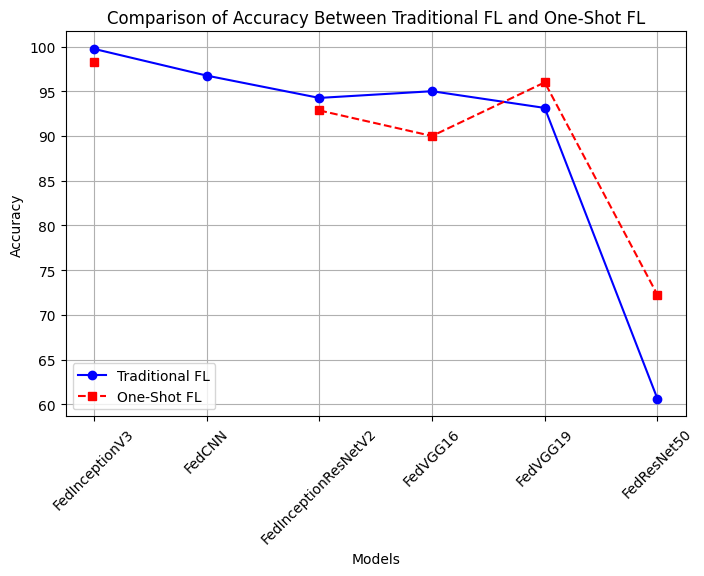

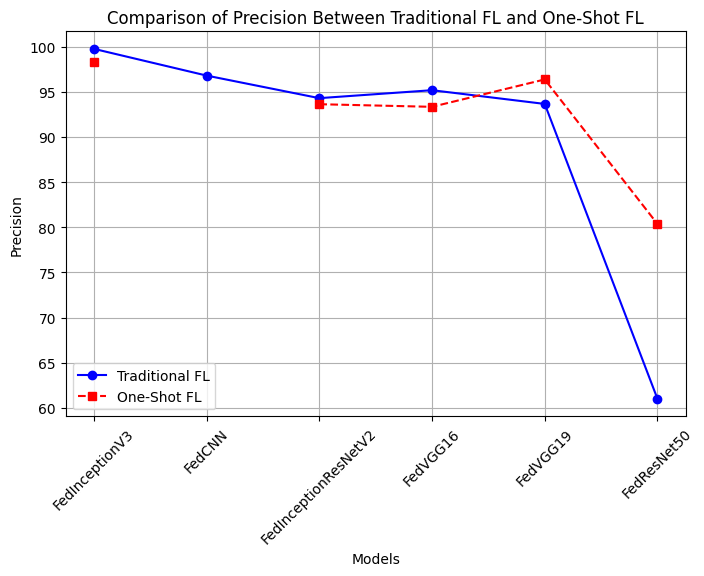

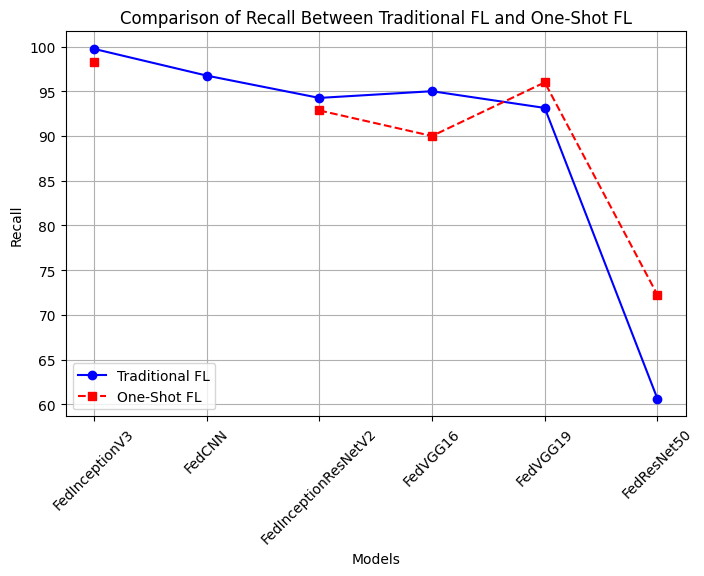

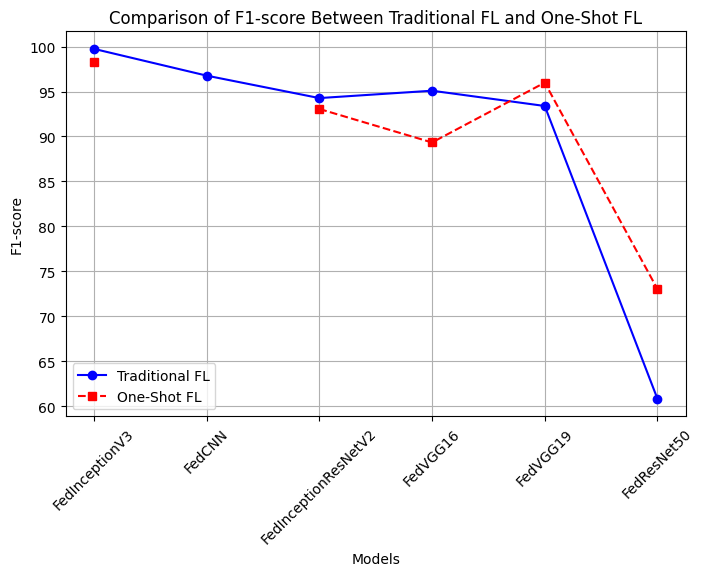

Graphs saved successfully!


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Data from the table
models = ["FedInceptionV3", "FedCNN", "FedInceptionResNetV2", "FedVGG16", "FedVGG19", "FedResNet50"]

accuracy_traditional = [99.75, 96.76, 94.26, 95.01, 93.14, 60.6]
accuracy_one_shot = [98.25, np.nan, 92.86, 90.00, 96.00, 72.22]

precision_traditional = [99.75, 96.79, 94.29, 95.17, 93.65, 61.00]
precision_one_shot = [98.34, np.nan, 93.62, 93.33, 96.36, 80.36]

recall_traditional = [99.75, 96.76, 94.26, 95.01, 93.14, 60.6]
recall_one_shot = [98.25, np.nan, 92.86, 90.00, 96.00, 72.22]

f1_traditional = [99.75, 96.77, 94.27, 95.09, 93.39, 60.8]
f1_one_shot = [98.25, np.nan, 93.06, 89.33, 95.99, 73.01]

# Metrics and titles
metrics = [
    (accuracy_traditional, accuracy_one_shot, "Accuracy"),
    (precision_traditional, precision_one_shot, "Precision"),
    (recall_traditional, recall_one_shot, "Recall"),
    (f1_traditional, f1_one_shot, "F1-score")
]

# Generate and save plots
for traditional, one_shot, metric_name in metrics:
    plt.figure(figsize=(8, 5))
    plt.plot(models, traditional, marker='o', linestyle='-', label='Traditional FL', color='b')
    plt.plot(models, one_shot, marker='s', linestyle='--', label='One-Shot FL', color='r')
    plt.xlabel("Models")
    plt.ylabel(metric_name)
    plt.title(f"Comparison of {metric_name} Between Traditional FL and One-Shot FL")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.savefig(f"comparison_{metric_name.lower()}.png", dpi=300, bbox_inches='tight')  # Save the figure
    plt.show()

print("Graphs saved successfully!")